In [1]:
# Classifies three types of foods: Donuts, Poutine and Samosas 
import torch

from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Load the dataset
# The original images are of the shape 512x512, which we will transform to 64x64
image_transforms = transforms.Compose(
    [transforms.Resize([64, 64]),
    transforms.ToTensor()]
)
train_dataset = datasets.ImageFolder(root='./datasets/food3/training/', transform=image_transforms)
test_dataset = datasets.ImageFolder(root='./datasets/food3/testing/', transform=image_transforms)

In [5]:
# Size of the total training dataset
len(train_dataset), len(test_dataset)

(2700, 300)

In [6]:
# All the classes of the train dataset
data_classes = train_dataset.classes
data_classes

['donut', 'poutine', 'samosa']

In [7]:
# Get the first image from the training dataset
image_tensor, label = train_dataset[0]
image_tensor.shape, label

(torch.Size([3, 64, 64]), 0)

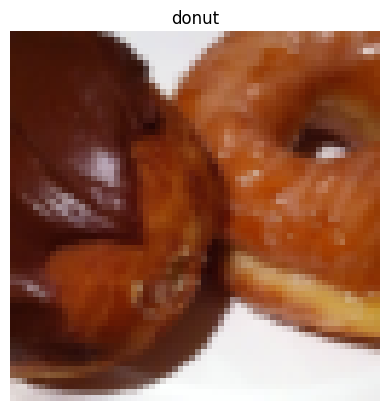

In [8]:
# Visualize the image
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis(False)
plt.title(data_classes[label])
plt.imshow(image_tensor.permute(1, 2, 0)) # Convert from pytorch's (C, H, W) format to (H, W, C) as matplotlib expects.

In [9]:
# Convert the entire training set into batches of data
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Get the batches of data from the dataloader
train_iterator = iter(train_dataloader)
test_iterator = iter(test_dataloader)

first_batch_images, first_batch_labels = next(train_iterator)
first_batch_images.shape, first_batch_labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [11]:
len(train_dataloader) # Total number of batches of data

85

In [12]:
# Let's see the first 5 images of our first batch of images to check if shuffling was done or not 
def show_torch_image(image):
    plt.imshow(image.permute(1, 2, 0))

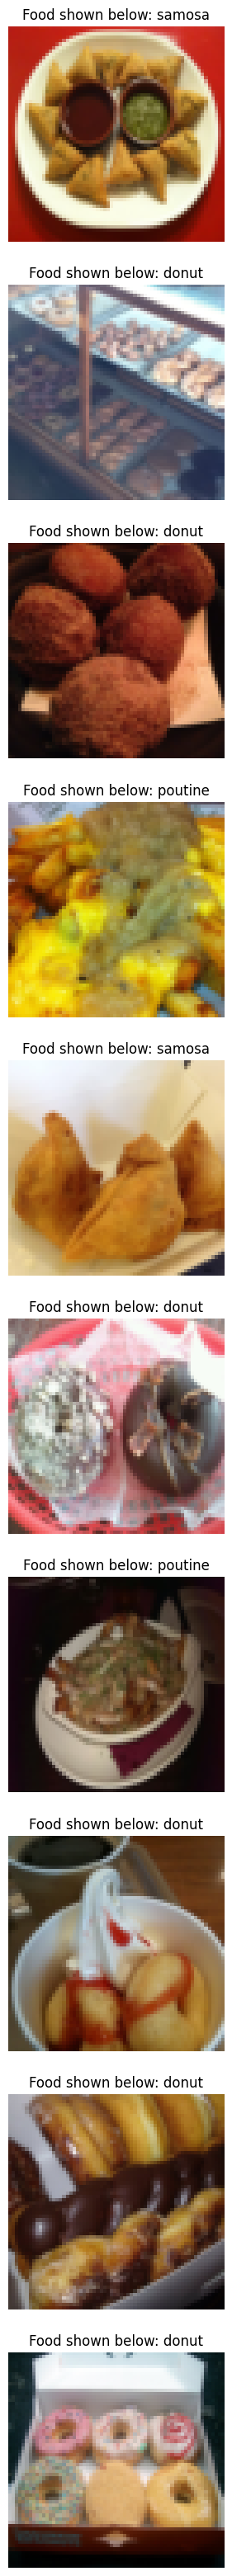

In [13]:
# Create the canvas
fig = plt.figure(figsize=(20, 40)) # W -> 20 inches, H -> 20 inches 
img_count = 10
for i in range(1, img_count+1):
    plt.subplot(img_count, 1, i)
    plt.axis(False)
    plt.title(f'Food shown below: {data_classes[first_batch_labels[i]]}')
    show_torch_image(first_batch_images[i])

In [14]:
# Looks like data was shuffeled ok.
# Now, let's create the model.

# The model will start from a standard CNN of 2 Convolution layers and a classifier layer consisting of 1 fully connected layer.  

# To know the output shape of a single image tensor after passing it through the convolution layers, we will first pass a dummy image data through
# the two convolution layers. We will create a function for it in case we need to change the convolution layer's constituents.

def check_conv_output(input_image): # (B, C, H, W). For our single RGB image, (1, 3, 64, 64)
    '''
    Returns a dictonary containing {input_shape: , output_shape: } after passing it through the desired convolution layers.
    '''
    conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10, 
                  kernel_size=(2, 2), stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2))
    )
    conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, 
                  kernel_size=(2, 2), stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2))
    )

    output_image = conv_layer_2(conv_layer_1(input_image))
    return {'input_shape': input_image.shape, 'output_shape': output_image.shape}

In [15]:
image_sample = first_batch_images[0]
image_sample = image_sample.unsqueeze(dim=0) # (C, H, W) -> (1, C, H, W)
image_sample.shape

torch.Size([1, 3, 64, 64])

In [16]:
output = check_conv_output(image_sample)
output['input_shape'], output['output_shape']

(torch.Size([1, 3, 64, 64]), torch.Size([1, 10, 15, 15]))

In [17]:
# Now that we know the output shape of our image tensor after passing it through the convolution layers, we can define the model
class FCM_NC3(nn.Module): # Food Classifier Model - Num Classes 3
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, 
                      kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, 
                      kernel_size=(2, 2), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2250, out_features=len(data_classes)) # in_features = 10*15*15 = 2250
        )

    def forward(self, X):
        conv_output = self.conv_layer_2(self.conv_layer_1(X))
        classifier_output = self.classifier_layer(conv_output)
        return classifier_output

In [18]:
# Check if the model is working or not by passing a single image tensor through it
sample_image = first_batch_images[5] # Fifth image from the first batch
sample_image = sample_image.unsqueeze(dim=0)

label = first_batch_labels[5] # Its corresponding label

sample_image.shape, label

(torch.Size([1, 3, 64, 64]), tensor(2))

In [19]:
torch.manual_seed(7320)
model = FCM_NC3().to(device) # Instantiate the model

In [20]:
# Passing a single image tensor through the model
logits = model(sample_image.to(device))
logits

tensor([[-0.0081,  0.0174, -0.0180]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [21]:
# The model's prediction before training it (garbage)
predicted_class = logits.argmax(dim=1)
print(f'Model prediction before training: {data_classes[predicted_class.item()]}')

Model prediction before training: poutine


In [22]:
# Create the loss function and the optimizer
loss_function = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

In [23]:
# Accuracy function
def calculate_accuracy(batch_logits, batch_labels):
    pred_classes = batch_logits.argmax(dim=1)
    num_correct_classes = (pred_classes == batch_labels).sum()

    accuracy = (num_correct_classes / len(batch_labels)) * 100.0
    return accuracy

In [24]:
# Training and Testing loops
def train_step(batches_X, labels_y):
    '''
    Sends a batch of training data through the model, calculates the loss, performs backpropagation and updates the model's parameters.
    RETURN VALUE(s): The loss of the current training setp.
    '''
    # Forward pass
    logits = model(batches_X.to(device))

    # Calculate the loss
    loss = loss_function(logits, labels_y)

    # Clear the gradients stored in the model's parameters from previous backpropagation
    optimizer.zero_grad()

    # Backpropagation (Calculate the gradients)
    loss.backward()

    # Update the model's parameters
    optimizer.step()

    return loss.item()

In [25]:
def test_step(test_dataloader):
    '''
    Sends the entire testing dataset through the model and calculates model's performance on the testing set.
    RETURN VALUE(s): A python dict containing i. The loss of the current testing step and ii. The accuracy of the model on the testing set.
    '''
    average_loss = 0
    average_accuracy = 0 # TODO
    for [X, y] in test_dataloader:
        logits = model(X.to(device))
        
        loss = loss_function(logits, y.to(device))
        average_loss += loss.item()
        average_accuracy += calculate_accuracy(logits, y.to(device))

    average_loss /= len(test_dataloader)
    average_accuracy /= len(test_dataloader)
    
    return {'loss': average_loss, 'accuracy': average_accuracy}

In [26]:
# Train the model
epochs = 100
for i in range(0, epochs):
    batch = 1
    print(f'---------- Epoch: {i} ----------')
    for [X, y] in train_dataloader:
        # Train the model
        train_loss = train_step(X.to(device), y.to(device))

        # Only start testing the model once you reach epoch 90
        if i > 10:
            # Test the model
            stats = test_step(test_dataloader)
            test_loss = stats['loss']
            test_accuracy = stats['accuracy']
            
        if batch%20 == 0 and i > 10:
            print(f'Batches seen: {batch}/{len(train_dataloader)}. Training Loss: {train_loss}. Testing loss: {test_loss}. Test Accuracy: {test_accuracy}')
        elif batch%20 == 0:
            print(f'Batches seen: {batch}/{len(train_dataloader)}. Training Loss: {train_loss}.')
            
        batch += 1

---------- Epoch: 0 ----------
Batches seen: 20/85. Training Loss: 1.0727914571762085.
Batches seen: 40/85. Training Loss: 1.0932683944702148.
Batches seen: 60/85. Training Loss: 1.0789629220962524.
Batches seen: 80/85. Training Loss: 1.101053237915039.
---------- Epoch: 1 ----------
Batches seen: 20/85. Training Loss: 1.02527916431427.
Batches seen: 40/85. Training Loss: 0.9772782921791077.
Batches seen: 60/85. Training Loss: 1.0391261577606201.
Batches seen: 80/85. Training Loss: 0.968313992023468.
---------- Epoch: 2 ----------
Batches seen: 20/85. Training Loss: 0.9517945647239685.
Batches seen: 40/85. Training Loss: 0.9561102986335754.
Batches seen: 60/85. Training Loss: 0.9157190322875977.
Batches seen: 80/85. Training Loss: 0.9322320222854614.
---------- Epoch: 3 ----------
Batches seen: 20/85. Training Loss: 1.0289108753204346.
Batches seen: 40/85. Training Loss: 1.0365676879882812.
Batches seen: 60/85. Training Loss: 1.0536304712295532.
Batches seen: 80/85. Training Loss: 1.01

KeyboardInterrupt: 